FNO Training Data Generator (robust materials) with res_factor = 1
Original jmax: 3000, scaled jmax: 3000, nmax: 12000, scaled nmax: 12000
dx: 25.000 nm, domain length: 75.00 μm, dt: 0.042 fs
Left vacuum end: 600, Right vacuum start: 2400
Measurement point: 2700
Estimated steps to arrival: 8400, spectrum start: 7200


 12%|█▏        | 58/500 [00:49<06:21,  1.16it/s]


⚠️ Warning sample 57: Pulse may not have reached measurement point! Ratio: 1.374e-03


 14%|█▎        | 68/500 [00:57<06:16,  1.15it/s]


⚠️ Warning sample 67: Pulse may not have reached measurement point! Ratio: 3.455e-03


 23%|██▎       | 115/500 [01:38<05:26,  1.18it/s]


⚠️ Warning sample 114: Pulse may not have reached measurement point! Ratio: 9.109e-03


 29%|██▉       | 146/500 [02:05<05:31,  1.07it/s]


⚠️ Warning sample 145: Pulse may not have reached measurement point! Ratio: 4.945e-03


 32%|███▏      | 161/500 [02:24<07:24,  1.31s/it]


⚠️ Warning sample 160: Pulse may not have reached measurement point! Ratio: 7.312e-03


 35%|███▌      | 176/500 [02:39<04:59,  1.08it/s]


⚠️ Warning sample 175: Pulse may not have reached measurement point! Ratio: 8.958e-04


 41%|████      | 205/500 [03:07<04:39,  1.06it/s]


⚠️ Warning sample 204: Pulse may not have reached measurement point! Ratio: 4.249e-04


 48%|████▊     | 240/500 [03:36<03:39,  1.18it/s]


⚠️ Warning sample 239: Pulse may not have reached measurement point! Ratio: 2.709e-03


 50%|████▉     | 248/500 [03:43<03:35,  1.17it/s]


⚠️ Warning sample 247: Pulse may not have reached measurement point! Ratio: 1.055e-04


 57%|█████▋    | 285/500 [04:15<03:20,  1.07it/s]


⚠️ Warning sample 284: Pulse may not have reached measurement point! Ratio: 4.864e-04


 62%|██████▏   | 308/500 [04:35<02:52,  1.12it/s]


⚠️ Warning sample 307: Pulse may not have reached measurement point! Ratio: 1.404e-03


 67%|██████▋   | 336/500 [05:00<02:35,  1.05it/s]


⚠️ Warning sample 335: Pulse may not have reached measurement point! Ratio: 7.141e-03


 84%|████████▍ | 419/500 [06:14<01:12,  1.12it/s]


⚠️ Warning sample 418: Pulse may not have reached measurement point! Ratio: 9.119e-04


 90%|█████████ | 452/500 [06:42<00:41,  1.16it/s]


⚠️ Warning sample 451: Pulse may not have reached measurement point! Ratio: 9.116e-04


 92%|█████████▏| 460/500 [06:49<00:34,  1.16it/s]


⚠️ Warning sample 459: Pulse may not have reached measurement point! Ratio: 8.694e-03


100%|██████████| 500/500 [07:23<00:00,  1.13it/s]



Dataset written to fdtd_fno_training_fixed_materials2.h5
Saved plot to: training_sample_example_fixed_materials.png


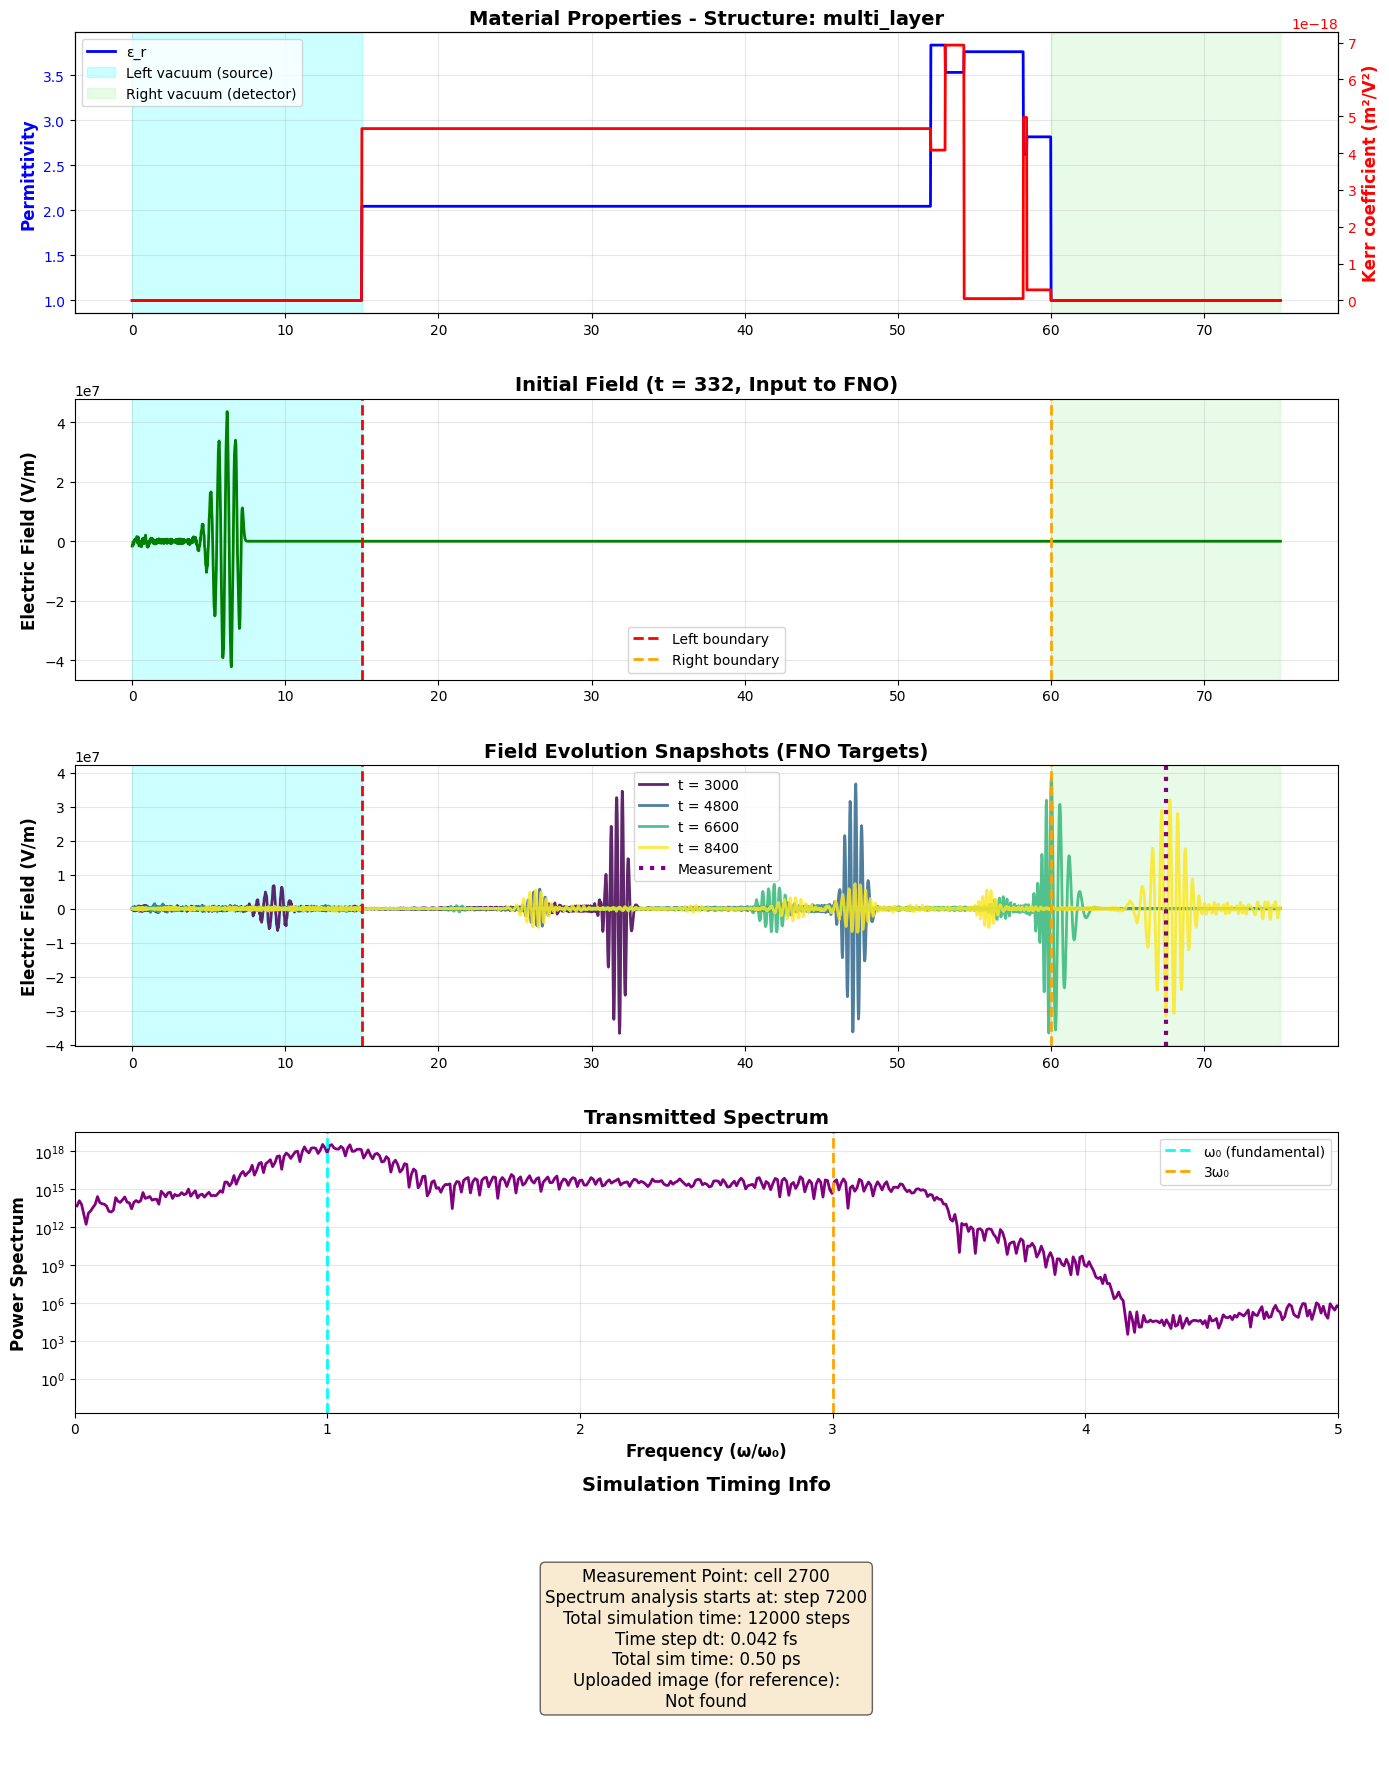


Compare with uploaded image at: /mnt/data/8353d242-432d-4972-84bf-96f9b262cf59.png


In [ ]:
"""
FDTD data generator. Includes PML boundary conditions, random material distributions, Kerr nonlinearity
"""

import numpy as np
import scipy.constants as sci
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# ---------------------------
# Config / Safety params
# ---------------------------
N2_GLOBAL_MAX = 8e-18     # clamp for Kerr coefficient
EX_AMPLITUDE_MAX = 6e7    # max source amplitude
PML_CELLS = 120           # pml-like mask size on each side
PML_STRENGTH = 1e-3       # reduced to avoid killing fields

# ---------------------------
# Standard PML (perfectly mathced layers)
# ---------------------------
def make_pml_mask(jmax, npml=PML_CELLS, strength=PML_STRENGTH):
    mask = np.ones(jmax, dtype=np.float64)
    if npml <= 0:
        return mask

    idx = np.arange(npml)
    profile = ((npml - idx) / npml)
    sigma = (profile**2) * strength
    mask_left = np.exp(-sigma)
    mask[:npml] = mask[:npml] * mask_left

    idx2 = np.arange(npml-1, -1, -1)
    profile2 = ((npml - idx2) / npml)
    sigma2 = (profile2**2) * strength
    mask_right = np.exp(-sigma2)
    mask[-npml:] = mask[-npml:] * mask_right

    return mask

# ---------------------------
# FDTD core (leapfrog using Yee cell)
# ---------------------------
def FDTD1D_simulate(jmax, nmax, dx, dt, source_function, eps_r=1.0, mu_r=1.0,
                    n2=0.0, pml_cells=PML_CELLS):
    """
    1D FDTD simulation (E-H) with optional Kerr nonlinearity.
    Resolution parameter should not change physical system hopefully
    """
    # Ensure arrays. 
    eps_r1 = eps_r if hasattr(eps_r, '__len__') else np.ones(jmax) * eps_r
    mu_r1 = mu_r if hasattr(mu_r, '__len__') else np.ones(jmax) * mu_r
    n2_arr = n2 if hasattr(n2, '__len__') else np.ones(jmax) * n2
    n2_arr = np.clip(n2_arr, 0.0, N2_GLOBAL_MAX)

    eps_linear = eps_r1 * sci.epsilon_0
    mu = mu_r1 * sci.mu_0
    imp0 = np.sqrt(sci.mu_0 / sci.epsilon_0)

    # Source placement: After PML
    jsource = max(pml_cells + 5, int(jmax * 0.02))

    # Fields
    Ex = np.zeros(jmax, dtype=np.float64)
    Hz = np.zeros(jmax, dtype=np.float64)
    Ex_prev = np.zeros_like(Ex)
    Hz_prev = np.zeros_like(Hz)

    # History for snapshots
    Ex_history = np.zeros((nmax, jmax), dtype=np.float32)
    Hz_history = np.zeros((nmax, jmax), dtype=np.float32)

    # PML mask
    pml_mask = make_pml_mask(jmax, npml=pml_cells)
    dt_over_dx = dt / dx

    for n in range(nmax):
        # ----- Update H -----
        Hz[:-1] = Hz_prev[:-1] + dt_over_dx / mu[1:] * (Ex[1:] - Ex[:-1])
        Hz[-1] = Hz[-2]  # simple boundary
        Hz[jsource-1] -= source_function(n) / imp0
        Hz *= pml_mask

        # ----- Update E -----
        Ex_intensity = Ex_prev**2
        eps_nonlinear = eps_linear + 3.0 * sci.epsilon_0 * n2_arr * Ex_intensity     #Effective eps incorporating Kerr nonlinearity.
        eps_nonlinear = np.maximum(eps_nonlinear, 1e-20)  # avoid div by zero

        Ex[1:] = Ex_prev[1:] + dt_over_dx / eps_nonlinear[1:] * (Hz[1:] - Hz[:-1])
        Ex[0] = Ex[1]  # boundary
        Ex[jsource] += source_function(n+1)
        Ex *= pml_mask

        # Save history
        Ex_history[n] = Ex.astype(np.float32)
        Hz_history[n] = Hz.astype(np.float32)

        # Prepare for next step
        Ex_prev[:] = Ex
        Hz_prev[:] = Hz

    return Ex_history, Hz_history


def generate_material_structure(jmax, vacuum_left_end, vacuum_right_start, dx, structure_type=None):
    """
    Physically consistent material generator.
    """
    #Tweak this to exclude types of structures
    if structure_type is None:
        structure_type = np.random.choice([
            'uniform', 'single_barrier', 'multi_layer', 'gradient',
            'periodic', 'waveguide', 'cavity',
            'random_smooth', 
        ]) # Removed chirped periodic and defect periodic because small details caused numerical instability

    eps_r = np.ones(jmax)
    n2 = np.zeros(jmax)
    jmaterial = max(1, vacuum_right_start - vacuum_left_end)
    material_region = slice(vacuum_left_end, vacuum_right_start)

    # Convert physical width in meters to cell count
    def meters_to_cells(width_m):
        return max(1, int(round(width_m / dx)))

    # Clamp indices to material region
    def clamp_slice(s, e):
        s2 = max(vacuum_left_end, int(round(s)))
        e2 = min(vacuum_right_start, int(round(e)))
        if e2 <= s2:
            e2 = min(vacuum_right_start, s2 + 1)
        return s2, e2

    x_material = np.arange(jmaterial)

    # -------------------------
    # Different structure types
    # -------------------------
    if structure_type == 'uniform':
        eps_r[material_region] = np.random.uniform(1.5, 3.0)
        n2[material_region] = np.random.uniform(0, 1e-17)

    elif structure_type == 'single_barrier':
        eps_r[material_region] = np.random.uniform(1.0, 1.6)
        barrier_width = meters_to_cells(np.random.uniform(0.5e-6, 3e-6))
        start_rel = np.random.randint(0, max(1, jmaterial - barrier_width))
        s, e = clamp_slice(vacuum_left_end + start_rel, vacuum_left_end + start_rel + barrier_width)
        eps_r[s:e] = np.random.uniform(2.0, 3.5)
        n2[s:e] = np.random.uniform(1e-18, 1e-17)

    elif structure_type == 'multi_layer':
        n_layers = np.random.randint(2, max(3, min(8, jmaterial // meters_to_cells(0.1e-6))))
        remaining = jmaterial
        pos = vacuum_left_end
        for li in range(n_layers):
            if li == n_layers - 1:
                w = remaining
            else:
                min_w = meters_to_cells(0.1e-6)
                max_w = remaining - (n_layers - li - 1)*min_w
                w = np.random.randint(min_w, max_w+1)
            s, e = clamp_slice(pos, pos + w)
            eps_r[s:e] = np.random.uniform(1.6, 4.0)
            n2[s:e] = np.random.uniform(0, 8e-18)
            remaining -= (e - s)
            pos = e
            if remaining <= 0:
                break

    elif structure_type == 'gradient':
        width_cells = meters_to_cells(np.random.uniform(0.5e-6, 5e-6))
        center = np.random.randint(vacuum_left_end + width_cells, vacuum_right_start - width_cells)
        rel_positions = np.arange(jmax)
        profile = np.exp(-((rel_positions - center)/width_cells)**2)
        eps_r[material_region] = 1.0 + (np.random.uniform(2.0, 4.0)-1.0) * profile[material_region]
        n2[material_region] = 8e-18 * profile[material_region]

    elif structure_type == 'periodic':
        period_cells = meters_to_cells(np.random.uniform(0.5e-6, 3e-6))
        duty_cycle = np.random.uniform(0.3, 0.7)
        eps_high = np.random.uniform(2.5, 4.0)
        eps_low = np.random.uniform(1.3, 2.2)
        eps_r[material_region] = eps_low
        pos = vacuum_left_end
        while pos < vacuum_right_start:
            cut = max(1, int(period_cells * duty_cycle))
            s, e = clamp_slice(pos, pos + cut)
            eps_r[s:e] = eps_high
            n2[s:e] = np.random.uniform(0, 8e-18)
            pos += period_cells

    elif structure_type == 'waveguide':
        cladding_n = np.random.uniform(1.3, 1.5)
        n_core_delta = np.random.uniform(0.05, 0.25)
        core_width = meters_to_cells(np.random.uniform(1e-6, 5e-6))
        center = jmaterial // 2
        core_start = max(0, center - core_width//2)
        core_end = min(jmaterial, core_start + core_width)
        eps_r[material_region] = cladding_n**2
        s, e = clamp_slice(vacuum_left_end + core_start, vacuum_left_end + core_end)
        eps_r[s:e] = (cladding_n + n_core_delta)**2
        n2[s:e] = np.random.uniform(1e-18, 8e-18)

    else:
        # fallback: gently random smooth profile
        n_features = max(3, min(8, jmaterial // meters_to_cells(0.1e-6)))
        eps_base = np.random.uniform(1.5, 3.5, n_features)
        n2_base = np.random.uniform(0, 1e-17, n_features)
        x_features = np.linspace(0, jmaterial-1, n_features)
        eps_profile = np.interp(x_material, x_features, eps_base)
        n2_profile = np.interp(x_material, x_features, n2_base)
        sigma_cells = max(1, jmaterial//20)
        eps_r[material_region] = gaussian_filter1d(eps_profile, sigma=sigma_cells)
        n2[material_region] = gaussian_filter1d(n2_profile, sigma=sigma_cells)

    # Clamp Kerr coefficient
    n2 = np.clip(n2, 0.0, N2_GLOBAL_MAX)
    return eps_r, n2, structure_type


def generate_gaussian_source(nmax, dt, wavelength_range=(400e-9, 800e-9),
                             t0_physical_range=(2e-15, 6e-15),
                             spread_physical_range=(2e-15, 4e-15),
                             amplitude_range=(1e7, EX_AMPLITUDE_MAX)):
    """
    Generates a Gaussian-modulated source pulse with consistent physical width
    independent of spatial resolution.
    
    Parameters:
        nmax : int
            Number of time steps (for reference if needed).
        dt : float
            Time step in seconds.
        wavelength_range : tuple
            (min, max) wavelengths in meters.
        t0_physical_range : tuple
            Pulse peak arrival time in seconds.
        spread_physical_range : tuple
            Pulse width (standard deviation) in seconds.
        amplitude_range : tuple
            Source amplitude range (V/m).
    
    Returns:
        source : function
            Callable source(n) that returns Ex at time step n.
        wavelength : float
            Carrier wavelength used.
        t0 : float
            Peak time in seconds.
        spread : float
            Temporal standard deviation in seconds.
        amplitude : float
            Source amplitude in V/m.
    """
    # Physical parameters
    t0 = np.random.uniform(*t0_physical_range)
    spread = np.random.uniform(*spread_physical_range)
    amplitude = np.random.uniform(*amplitude_range)
    wavelength = np.random.uniform(*wavelength_range)
    omega_carrier = 2 * np.pi * sci.c / wavelength

    def source(n):
        t = n * dt
        envelope = np.exp(-((t - t0) / spread) ** 2)
        carrier = np.cos(omega_carrier * t)
        return amplitude * envelope * carrier

    return source, wavelength, t0, spread, amplitude


# ---------------------------
# Spectrum. Computes FFT at measurement point (which is placed in vacuum on right of material)
# ---------------------------
def compute_spectrum(Ex_history, dt, measurement_point, window_start=None):
    signal = Ex_history[:, measurement_point]
    if window_start is not None:
        if window_start >= len(signal):
            window_start = len(signal) // 2
        if window_start < 0:
            window_start = 0
        signal = signal[window_start:]
    if len(signal) < 10:
        signal = np.pad(signal, (0, 100 - len(signal)), mode='constant')
    window = np.hanning(len(signal))
    signal_windowed = signal * window
    fft_signal = fft(signal_windowed)
    power_spectrum = np.abs(fft_signal)**2
    frequencies = fftfreq(len(signal), dt)
    positive_freq_idx = frequencies > 0
    return frequencies[positive_freq_idx], power_spectrum[positive_freq_idx]


#Finds a time where the source is fully developed but not contacted material yet for FNO input
def find_initial_snapshot_time(Ex_history, vacuum_left_end, threshold_ratio=0.05):
    max_field_in_vacuum = np.max(np.abs(Ex_history[:, :vacuum_left_end]))
    for t in range(Ex_history.shape[0]):
        mid_vacuum = max(50, vacuum_left_end // 2)
        left_check = Ex_history[t, max(0, mid_vacuum-40):min(vacuum_left_end, mid_vacuum+40)]
        field_at_mid = np.max(np.abs(left_check)) if left_check.size > 0 else 0.0
        near_check = Ex_history[t, max(0, vacuum_left_end-40):vacuum_left_end+40]
        field_near_material = np.max(np.abs(near_check)) if near_check.size > 0 else 0.0
        if (field_at_mid > 0.7 * max_field_in_vacuum and
            field_near_material < threshold_ratio * max_field_in_vacuum):
            return t
    source_region_max = np.max(np.abs(Ex_history[:, :100]), axis=1)
    return int(np.argmax(source_region_max))

# ---------------------------
# Dataset generation
# ---------------------------
def generate_training_dataset(n_samples, jmax=3000, nmax=12000,
                             output_file='fdtd_fno_training_fixed_materials2.h5',
                             vacuum_left_fraction=0.2,
                             vacuum_right_fraction=0.2,
                             nonlinear=True,
                             snapshot_times_relative=[0.25, 0.4, 0.55, 0.7],
                             res_factor=1.0):
    """
    Generates FDTD dataset with optional grid resolution factor.
    res_factor > 1 increases spatial resolution (more points, smaller dx)
    while keeping the physical domain and total simulation time constant.
    """

    # -------------------------
    # Original dx and domain length. Resolution scaling is based off of this
    # -------------------------
    lambda_min = 500e-9
    dx_original = lambda_min / 20
    L_phys = jmax * dx_original        # total physical domain length in meters
    dt_original = dx_original / (2 * sci.c)  # original CFL timestep
    T_phys = nmax * dt_original       # total physical simulation time

    # -------------------------
    # Scaled spatial grid
    # -------------------------
    jmax_scaled = int(jmax * res_factor)
    dx = L_phys / jmax_scaled             # new spacing
    dt = dx / (2 * sci.c)                 # CFL timestep for scaled grid

    # -------------------------
    # Scale nmax to maintain same total physical time
    # -------------------------
    nmax_scaled = int(T_phys / dt)
    if nmax_scaled < 1:
        nmax_scaled = 1

    # -------------------------
    # Vacuum boundaries & measurement point (fractions)
    # -------------------------
    vacuum_left_end = int(vacuum_left_fraction * jmax_scaled)
    vacuum_right_start = int((1 - vacuum_right_fraction) * jmax_scaled)
    measurement_point = vacuum_right_start + int((jmax_scaled - vacuum_right_start) * 0.5)

    # -------------------------
    # Snapshot times (scaled to nmax_scaled)
    # -------------------------
    snapshot_times = [int(t * nmax_scaled) for t in snapshot_times_relative]

    # -------------------------
    # Estimate propagation time. This is to check the transmitted wave actually reaches spectrum measurement point. Additionally, a good time window for the spectrum measurement is calculated.
    # -------------------------
    distance_to_measurement = (measurement_point - vacuum_left_end) * dx
    propagation_time_estimate = distance_to_measurement / (sci.c / 2)
    time_steps_needed = int(propagation_time_estimate / dt)
    time_steps_with_buffer = int(time_steps_needed * 1.5)
    spectrum_window_start = max(int(nmax_scaled * 0.4), min(time_steps_with_buffer, int(nmax_scaled * 0.6)))

    print("="*70)
    print("FNO Training Data Generator (robust materials) with res_factor =", res_factor)
    print("="*70)
    print(f"Original jmax: {jmax}, scaled jmax: {jmax_scaled}, nmax: {nmax}, scaled nmax: {nmax_scaled}")
    print(f"dx: {dx*1e9:.3f} nm, domain length: {L_phys*1e6:.2f} μm, dt: {dt*1e15:.3f} fs")
    print(f"Left vacuum end: {vacuum_left_end}, Right vacuum start: {vacuum_right_start}")
    print(f"Measurement point: {measurement_point}")
    print(f"Estimated steps to arrival: {time_steps_needed}, spectrum start: {spectrum_window_start}")
    print("="*70)



    with h5py.File(output_file, 'w') as f:
        ds_eps_r = f.create_dataset('eps_r', shape=(n_samples, jmax_scaled), dtype=np.float32)
        ds_n2 = f.create_dataset('n2', shape=(n_samples, jmax_scaled), dtype=np.float32)
        ds_initial_field = f.create_dataset('initial_field', shape=(n_samples, jmax_scaled), dtype=np.float32)
        ds_wavelength = f.create_dataset('wavelength', shape=(n_samples,), dtype=np.float32)
        ds_amplitude = f.create_dataset('amplitude', shape=(n_samples,), dtype=np.float32)
        ds_t0 = f.create_dataset('t0', shape=(n_samples,), dtype=np.float32)
        ds_spread = f.create_dataset('spread', shape=(n_samples,), dtype=np.float32)
        ds_structure_type = f.create_dataset('structure_type', shape=(n_samples,), dtype='S20')
        ds_snapshots = f.create_dataset('field_snapshots', shape=(n_samples, len(snapshot_times), jmax_scaled), dtype=np.float32)
        ds_final_field = f.create_dataset('final_field', shape=(n_samples, jmax_scaled), dtype=np.float32)


        f.attrs['jmax'] = jmax
        f.attrs['nmax'] = nmax
        f.attrs['vacuum_left_end'] = vacuum_left_end
        f.attrs['vacuum_right_start'] = vacuum_right_start
        f.attrs['measurement_point'] = measurement_point
        f.attrs['dx'] = dx
        f.attrs['dt'] = dt
        f.attrs['snapshot_times'] = snapshot_times
        f.attrs['spectrum_window_start'] = spectrum_window_start

        spectrum_list = []
        freq_list = []
        initial_time_list = []

        for i in tqdm(range(n_samples)):
            eps_r, n2_arr, struct_type = generate_material_structure(jmax_scaled, vacuum_left_end, vacuum_right_start, dx=dx)
            if nonlinear is False:
                n2_arr = np.zeros_like(n2_arr)
            n2_arr = np.clip(n2_arr, 0.0, N2_GLOBAL_MAX)

            source, wavelength, t0, spread, amplitude = generate_gaussian_source(nmax, dt)
            amplitude = float(np.clip(amplitude, 0.0, EX_AMPLITUDE_MAX))

            estimated_eps_kerr = 3.0 * sci.epsilon_0 * np.max(n2_arr) * (amplitude**2)
            if estimated_eps_kerr / sci.epsilon_0 > 5.0:
                print(f"\n⚠️ Sample {i}: estimated Kerr relative permittivity increase ~ {estimated_eps_kerr/sci.epsilon_0:.2f}")

            Ex_history, Hz_history = FDTD1D_simulate(jmax_scaled, nmax_scaled, dx, dt, source,
                                                     eps_r=eps_r, mu_r=1.0, n2=n2_arr,
                                                     pml_cells=PML_CELLS)

            initial_time = find_initial_snapshot_time(Ex_history, vacuum_left_end)
            initial_field = Ex_history[initial_time, :]

            snapshots = Ex_history[snapshot_times, :]

            max_field_at_measurement = np.max(np.abs(Ex_history[:, measurement_point]))
            max_field_overall = np.max(np.abs(Ex_history))
            arrival_ratio = max_field_at_measurement / (max_field_overall + 1e-30)
            if arrival_ratio < 0.01:
                print(f"\n⚠️ Warning sample {i}: Pulse may not have reached measurement point! Ratio: {arrival_ratio:.3e}")

            frequencies, power_spectrum = compute_spectrum(Ex_history, dt, measurement_point, window_start=spectrum_window_start)

            # Save to file
            ds_eps_r[i] = eps_r.astype(np.float32)
            ds_n2[i] = n2_arr.astype(np.float32)
            ds_initial_field[i] = initial_field.astype(np.float32)
            ds_wavelength[i] = wavelength
            ds_amplitude[i] = amplitude
            ds_t0[i] = t0
            ds_spread[i] = spread
            ds_structure_type[i] = struct_type.encode('utf-8')

            ds_snapshots[i] = snapshots.astype(np.float32)
            ds_final_field[i] = Ex_history[-1, :].astype(np.float32)

            spectrum_list.append(power_spectrum[:10000].astype(np.float32))
            freq_list.append(frequencies[:10000].astype(np.float32))
            initial_time_list.append(initial_time)

        for i_, (spec, freq, t_init) in enumerate(zip(spectrum_list, freq_list, initial_time_list)):
            f.create_dataset(f'spectrum_{i_}', data=spec)
            f.create_dataset(f'frequencies_{i_}', data=freq)
        f.create_dataset('initial_snapshot_times', data=np.array(initial_time_list))

        print("\nDataset written to", output_file)
    return output_file

# ---------------------------
# Plotting a sample
# ---------------------------
def plot_sample_from_file(h5file, idx=0, outfig='training_sample_example_fixed_materials2.png'):
    with h5py.File(h5file, 'r') as f:
        eps_r = f['eps_r'][idx]
        n2 = f['n2'][idx]
        initial_field = f['initial_field'][idx]
        snapshots = f['field_snapshots'][idx]
        structure = f['structure_type'][idx].decode('utf-8')
        vacuum_left = f.attrs['vacuum_left_end']
        vacuum_right = f.attrs['vacuum_right_start']
        wavelength = f['wavelength'][idx]
        initial_time = int(f['initial_snapshot_times'][idx])
        measurement_pt = int(f.attrs['measurement_point'])
        spectrum_start = int(f.attrs['spectrum_window_start'])
        dx = f.attrs['dx']
        dt = f.attrs['dt']

        x = np.arange(len(eps_r)) * dx * 1e6  # μm

        fig, axes = plt.subplots(5, 1, figsize=(14, 18), sharex=False)
        colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))

        # 1) Material
        ax1 = axes[0]
        ax1.plot(x, eps_r, 'b-', linewidth=2, label='ε_r')
        ax1.axvspan(0, x[vacuum_left], alpha=0.2, color='cyan', label='Left vacuum (source)')
        ax1.axvspan(x[vacuum_right], x[-1], alpha=0.2, color='lightgreen', label='Right vacuum (detector)')
        ax1.set_ylabel('Permittivity', fontsize=12, fontweight='bold', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1_twin = ax1.twinx()
        ax1_twin.plot(x, n2, 'r-', linewidth=2, label='n₂')
        ax1_twin.set_ylabel('Kerr coefficient (m²/V²)', fontsize=12, fontweight='bold', color='r')
        ax1_twin.tick_params(axis='y', labelcolor='r')
        ax1.set_title(f'Material Properties - Structure: {structure}', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')

        # 2) Initial field
        ax2 = axes[1]
        ax2.plot(x, initial_field, 'g-', linewidth=2)
        ax2.axvspan(0, x[vacuum_left], alpha=0.2, color='cyan')
        ax2.axvspan(x[vacuum_right], x[-1], alpha=0.2, color='lightgreen')
        ax2.axvline(x[vacuum_left], color='red', linestyle='--', linewidth=2, label='Left boundary')
        ax2.axvline(x[vacuum_right], color='orange', linestyle='--', linewidth=2, label='Right boundary')
        ax2.set_ylabel('Electric Field (V/m)', fontsize=12, fontweight='bold')
        ax2.set_title(f'Initial Field (t = {initial_time}, Input to FNO)', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

        # 3) Field snapshots
        ax3 = axes[2]
        snapshot_times = f.attrs['snapshot_times']
        for i_snap, (snap, color) in enumerate(zip(snapshots, colors)):
            ax3.plot(x, snap, label=f't = {snapshot_times[i_snap]}', alpha=0.85, linewidth=2, color=color)
        ax3.axvspan(0, x[vacuum_left], alpha=0.2, color='cyan')
        ax3.axvspan(x[vacuum_right], x[-1], alpha=0.2, color='lightgreen')
        ax3.axvline(x[vacuum_left], color='red', linestyle='--', linewidth=2)
        ax3.axvline(x[vacuum_right], color='orange', linestyle='--', linewidth=2)
        ax3.axvline(x[measurement_pt], color='purple', linestyle=':', linewidth=3, label='Measurement')
        ax3.set_ylabel('Electric Field (V/m)', fontsize=12, fontweight='bold')
        ax3.set_title('Field Evolution Snapshots (FNO Targets)', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

        # 4) Spectrum
        ax4 = axes[3]
        spectrum = f[f'spectrum_{idx}'][:]
        frequencies = f[f'frequencies_{idx}'][:]
        f0 = sci.c / wavelength
        ax4.semilogy(frequencies / f0, spectrum, linewidth=2, color='purple')
        ax4.axvline(1, color='cyan', linestyle='--', linewidth=2, label='ω₀ (fundamental)')
        ax4.axvline(3, color='orange', linestyle='--', linewidth=2, label='3ω₀')
        ax4.set_xlabel('Frequency (ω/ω₀)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Power Spectrum', fontsize=12, fontweight='bold')
        ax4.set_title('Transmitted Spectrum', fontsize=14, fontweight='bold')
        ax4.set_xlim(0, 5)
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=10)

        # 5) Timing/info box
        ax5 = axes[4]
        ax5.text(0.5, 0.5,
                 f'Measurement Point: cell {measurement_pt}\n'
                 f'Spectrum analysis starts at: step {spectrum_start}\n'
                 f'Total simulation time: {f.attrs["nmax"]} steps\n'
                 f'Time step dt: {dt*1e15:.3f} fs\n'
                 f'Total sim time: {f.attrs["nmax"]*dt*1e12:.2f} ps\n'
                 f'Uploaded image (for reference):\n{uploaded_image_path if os.path.exists(uploaded_image_path) else "Not found"}',
                 transform=ax5.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))
        ax5.set_title('Simulation Timing Info', fontsize=14, fontweight='bold')
        ax5.axis('off')

        plt.tight_layout()
        plt.savefig(outfig, dpi=150, bbox_inches='tight')
        print(f"Saved plot to: {outfig}")
        plt.show()

# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    # Generate one sample (tweak as needed)
    out_h5 = generate_training_dataset(
        n_samples=500,
        jmax=3000,
        nmax=12000,
        vacuum_left_fraction=0.2,
        vacuum_right_fraction=0.2,
        nonlinear=True,
        output_file='fdtd_fno_training_fixed_materials2.h5',
        res_factor=1
    )

    # Plot sample 0
    plot_sample_from_file(out_h5, idx=0, outfig='training_sample_example_fixed_materials.png')


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
lr,███████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁▁▁▁▁▂▁▃▂▃▃▆▅▆▅▃▆▅▆▆▆█▇▇▇▇█▇███▇██▇▇██▇▇
train_loss,█████▇▆▆▆▅▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
lr,0.0005
test_loss,1.29061
train_loss,0.0165


Using device: cuda
Dataset size: 500, Train: 400, Test: 100
x_train shape: torch.Size([400, 3, 3000]), y_train shape: torch.Size([400, 3000])
Epoch 20/100 | Train Loss: 0.289718 | Test Loss: 0.369940
Epoch 40/100 | Train Loss: 0.050916 | Test Loss: 0.464531
Epoch 60/100 | Train Loss: 0.021412 | Test Loss: 0.460298
Epoch 80/100 | Train Loss: 0.018450 | Test Loss: 0.456793
Epoch 100/100 | Train Loss: 0.013919 | Test Loss: 0.464922
Model saved to fdtd_fno_fields_only2.pth and logged as W&B artifact.


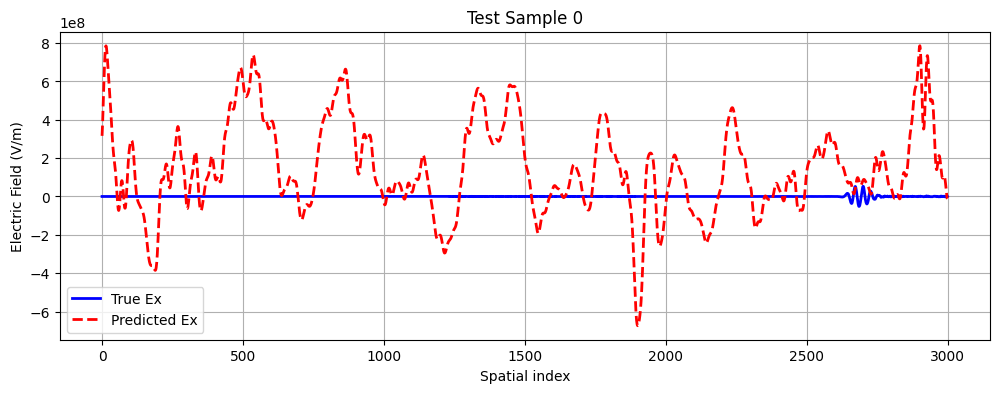

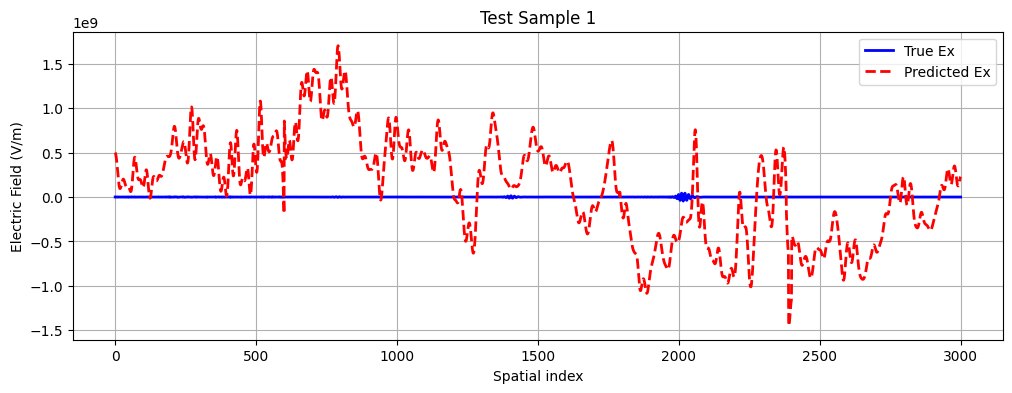

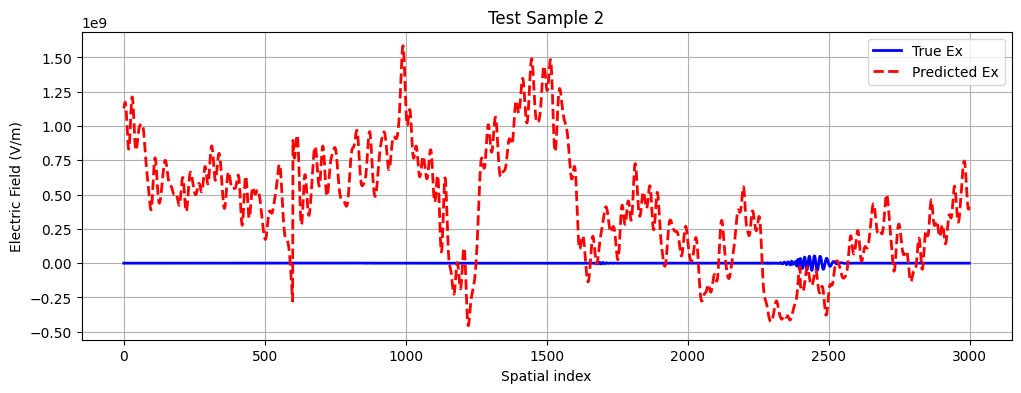

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from neuralop.models import FNO
import h5py
import wandb

# ----------------------------
# Config / hyperparameters
# ----------------------------
DATA_PATH = 'fdtd_fno_training_fixed_materials2.h5'
TRAIN_RATIO = 0.8  # fraction of data used for training
TEST_RATIO = 0.2   # fraction of data used for testing

wandb.init(
    project="fdtd-fno-fields-only",
    config={
        "n_modes": 300,
        "hidden_channels": 128,
        "n_layers": 6,
        "learning_rate": 1e-3,
        "epochs": 100,
        "batch_size": 20
    }
)
config = wandb.config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ----------------------------
# Load dataset
# ----------------------------
with h5py.File(DATA_PATH, 'r') as f:
    x_data = f['initial_field'][:]            # (n_samples, jmax)
    y_data = f['field_snapshots'][:]          # (n_samples, n_snapshots, jmax)
    eps_r = f['eps_r'][:]
    n2 = f['n2'][:]

n_samples = x_data.shape[0]
n_train = int(TRAIN_RATIO * n_samples)
n_test = n_samples - n_train

# For simplicity, predict the second to last snapshot. May predict multiple snapshots in future
y_target = y_data[:, -2, :]  # shape: (n_samples, jmax)

# Stack input channels: initial field + eps_r + n2
x_input = np.stack([x_data, eps_r, n2], axis=1)  # (n_samples, 3, jmax)

# ----------------------------
# Normalize inputs and outputs
# ----------------------------
x_norm = x_input.copy()
y_norm = y_target.copy()
norm_stats = {}

for i, name in enumerate(['Ex', 'eps', 'n2']):
    mean = x_input[:, i, :].mean()
    std = x_input[:, i, :].std()
    norm_stats[f'{name}_mean'] = mean
    norm_stats[f'{name}_std'] = std
    x_norm[:, i, :] = (x_input[:, i, :] - mean) / (std + 1e-8)

y_mean = y_target.mean()
y_std = y_target.std()
y_norm = (y_target - y_mean) / (y_std + 1e-8)
norm_stats['y_mean'] = y_mean
norm_stats['y_std'] = y_std

# ----------------------------
# Train/test split
# ----------------------------
x_train = torch.FloatTensor(x_norm[:n_train]).to(device)
y_train = torch.FloatTensor(y_norm[:n_train]).to(device)
x_test = torch.FloatTensor(x_norm[-n_test:]).to(device)
y_test = torch.FloatTensor(y_norm[-n_test:]).to(device)

print(f"Dataset size: {n_samples}, Train: {n_train}, Test: {n_test}")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# ----------------------------
# Define FNO model
# ----------------------------
model = FNO(
    n_modes=(config.n_modes,),
    hidden_channels=config.hidden_channels,
    in_channels=3,
    out_channels=1,
    n_layers=config.n_layers
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = nn.MSELoss()

wandb.watch(model, log="all", log_freq=10)

# ----------------------------
# Training loop
# ----------------------------
train_losses = []
test_losses = []

for epoch in range(config.epochs):
    model.train()
    train_loss = 0.0
    for i in range(0, len(x_train), config.batch_size):
        batch_x = x_train[i:i+config.batch_size]
        batch_y = y_train[i:i+config.batch_size]

        optimizer.zero_grad()
        pred = model(batch_x).squeeze(1)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= max(1, len(x_train) // config.batch_size)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        test_pred = model(x_test).squeeze(1)
        test_loss = criterion(test_pred, y_test).item()
    test_losses.append(test_loss)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "lr": optimizer.param_groups[0]['lr']
    })

    scheduler.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{config.epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")


# Save model safely on Windows
# ----------------------------
model_path = 'fdtd_fno_fields_only2.pth'
torch.save(model.state_dict(), model_path)

# Create a W&B artifact
artifact = wandb.Artifact('fdtd_fno_fields_only2', type='model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

print(f"Model saved to {model_path} and logged as W&B artifact.")

# ----------------------------
# Plot example predictions
# ----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(x_test).squeeze(1).cpu().numpy()
    y_true = y_test.cpu().numpy()

# Denormalize
y_pred_denorm = y_pred * y_std + y_mean
y_true_denorm = y_true * y_std + y_mean

for sample_idx in range(min(3, n_test)):
    plt.figure(figsize=(12,4))
    plt.plot(y_true_denorm[sample_idx], 'b-', linewidth=2, label='True Ex')
    plt.plot(y_pred_denorm[sample_idx], 'r--', linewidth=2, label='Predicted Ex')
    plt.xlabel('Spatial index')
    plt.ylabel('Electric Field (V/m)')
    plt.title(f'Test Sample {sample_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Results ploting function
def plot_fno_prediction_with_material(x_coords, y_true, y_pred, eps_r, n2, sample_idx=0):
    """
    Plot FNO prediction vs true field and overlay material properties.

    Parameters
    ----------
    x_coords : array-like
        Spatial grid indices (or physical coordinates)
    y_true : array-like
        True electric field
    y_pred : array-like
        Predicted electric field
    eps_r : array-like
        Relative permittivity
    n2 : array-like
        Kerr coefficient
    sample_idx : int
        Index of the sample (for title)
    """
    plt.figure(figsize=(12,5))
    plt.plot(x_coords, y_true, 'r-', linewidth=2, label='True Ex')
    plt.plot(x_coords, y_pred, 'b-', linewidth=2, label='Predicted Ex')
    
    # Overlay material on a secondary axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(x_coords, eps_r, 'g-', alpha=0.6, linewidth=2, label='ε_r')
    ax2.plot(x_coords, n2, 'm-', alpha=0.6, linewidth=2, label='n₂')
    
    ax1.set_xlabel('Spatial index')
    ax1.set_ylabel('Electric Field (V/m)')
    ax2.set_ylabel('Material Properties')
    plt.title(f'FNO Prediction vs True - Sample {sample_idx}')
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.grid(True)
    plt.show()


In [ ]:
# Denormalize predictions and true field for plotting
y_pred_denorm = y_pred * y_std + y_mean
y_true_denorm = y_true * y_std + y_mean

# Spatial coordinates (indices or μm if you want)
x_coords = np.arange(y_true_denorm.shape[1])

# Test material properties
eps_r_test = eps_r[n_train:]  # select only test set
n2_test = n2[n_train:]


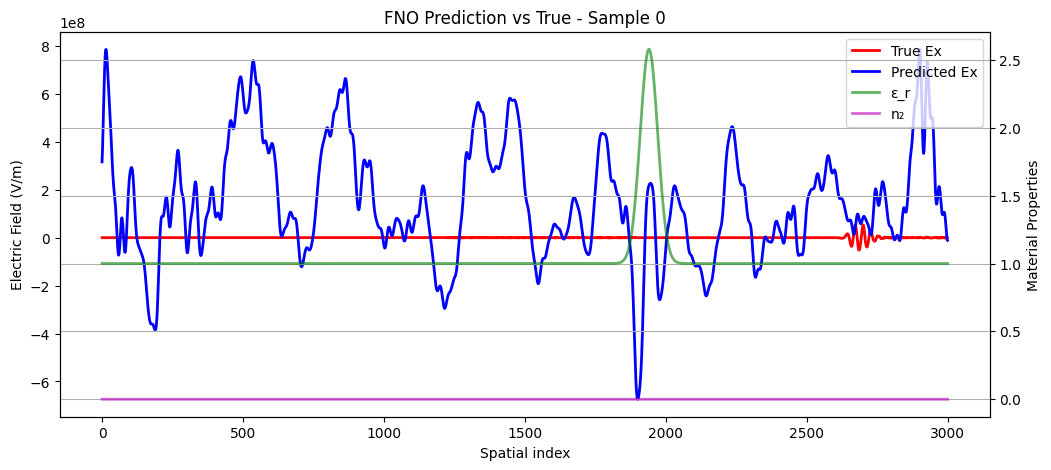

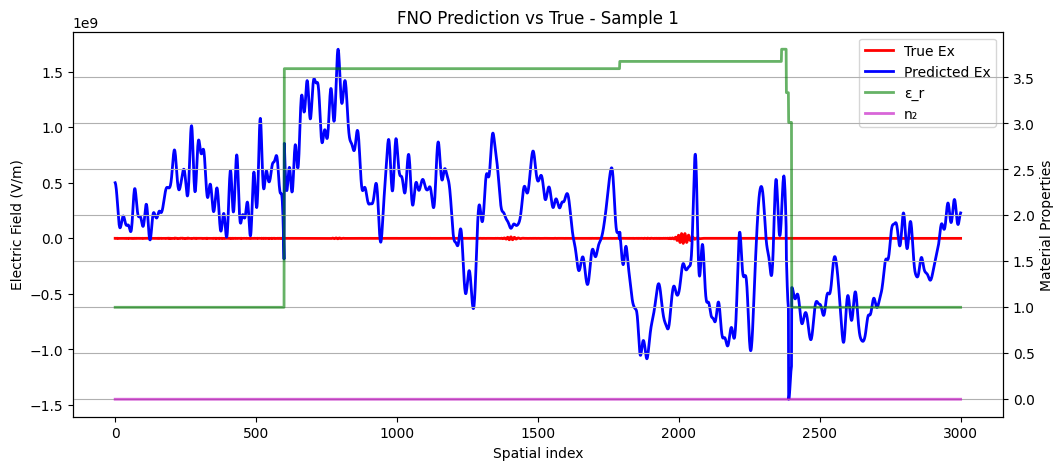

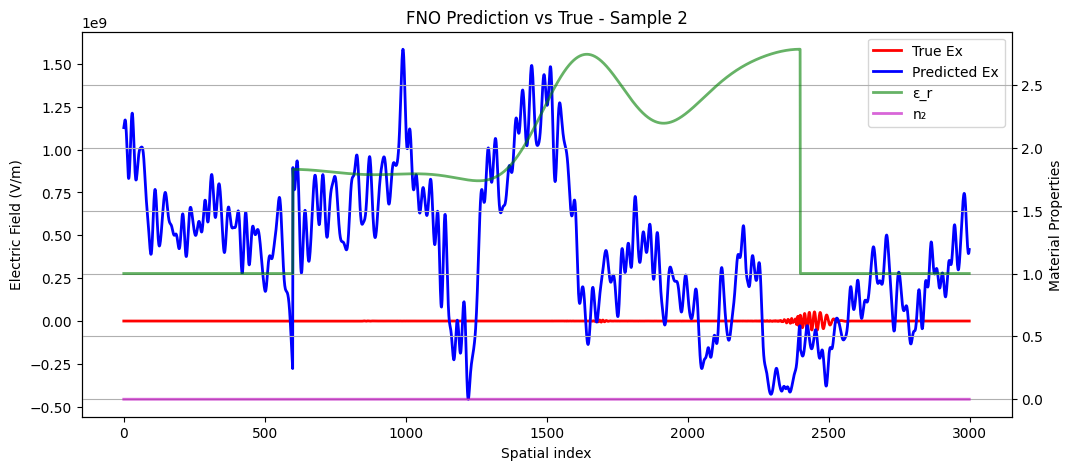

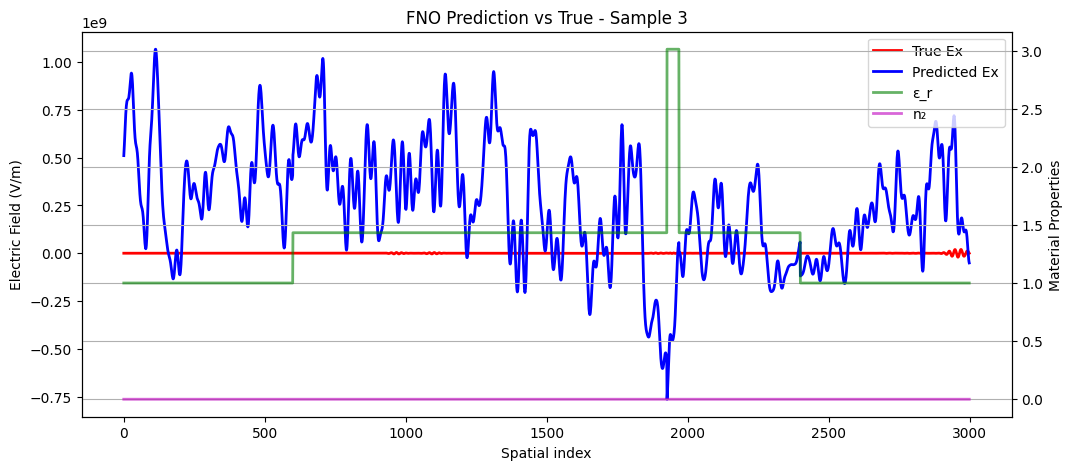

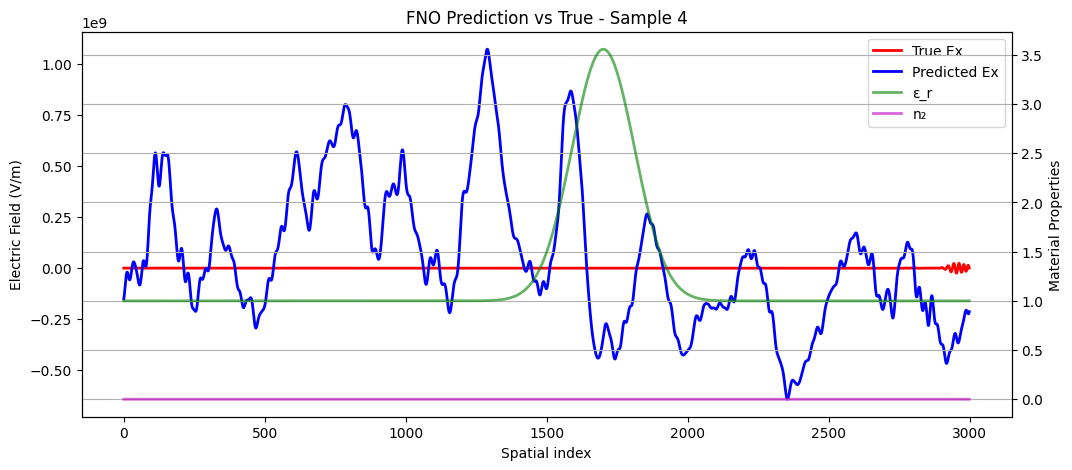

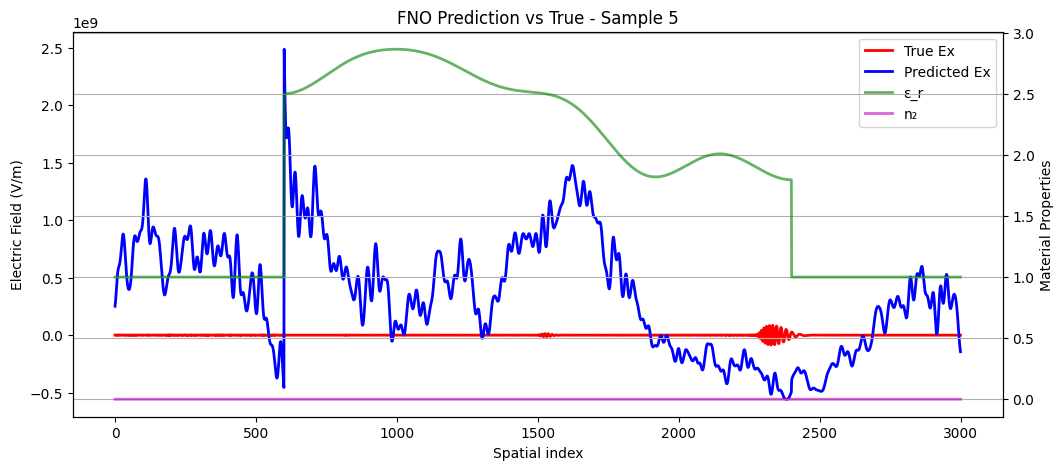

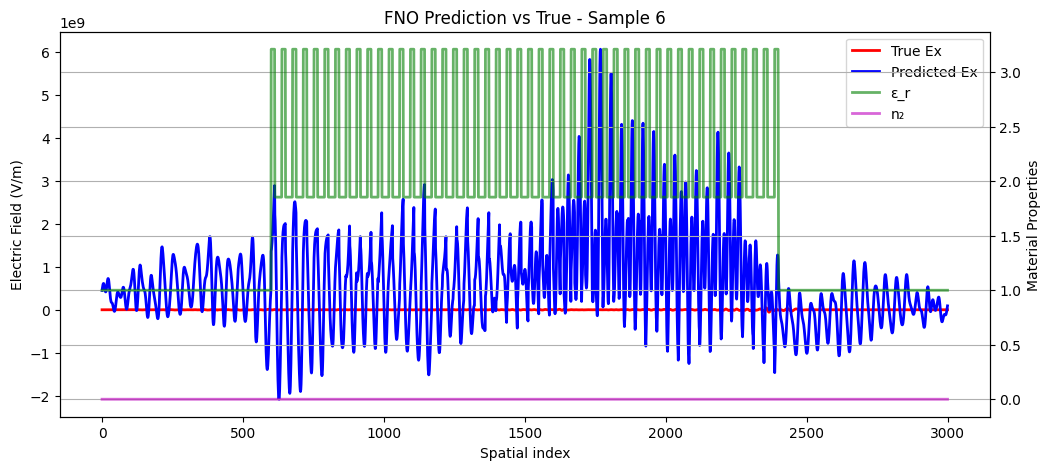

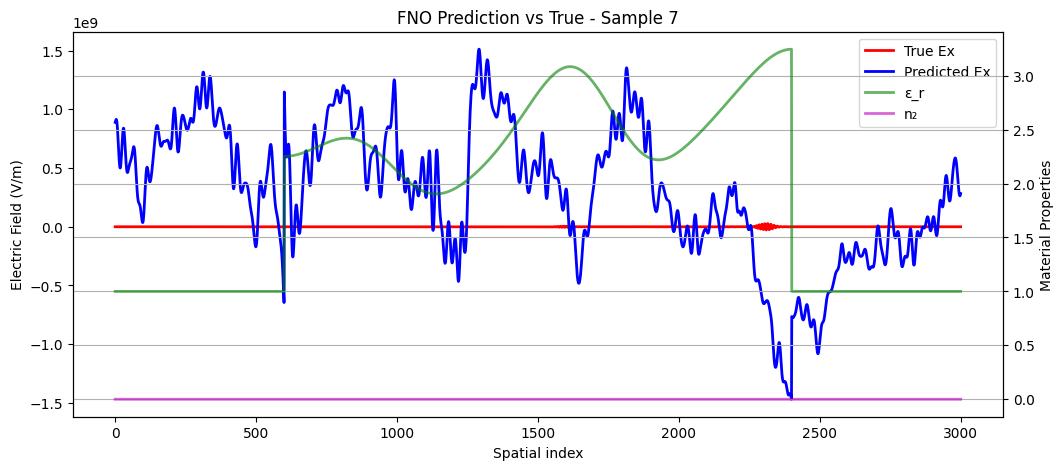

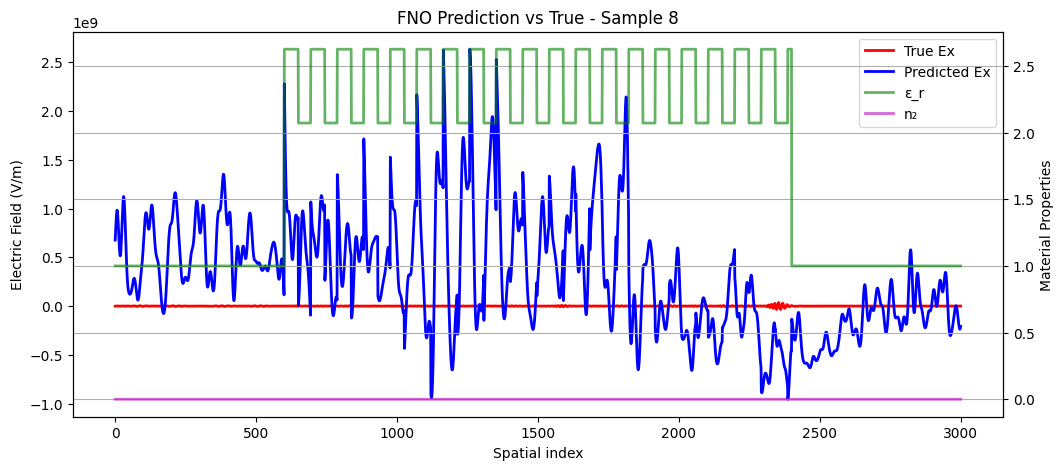

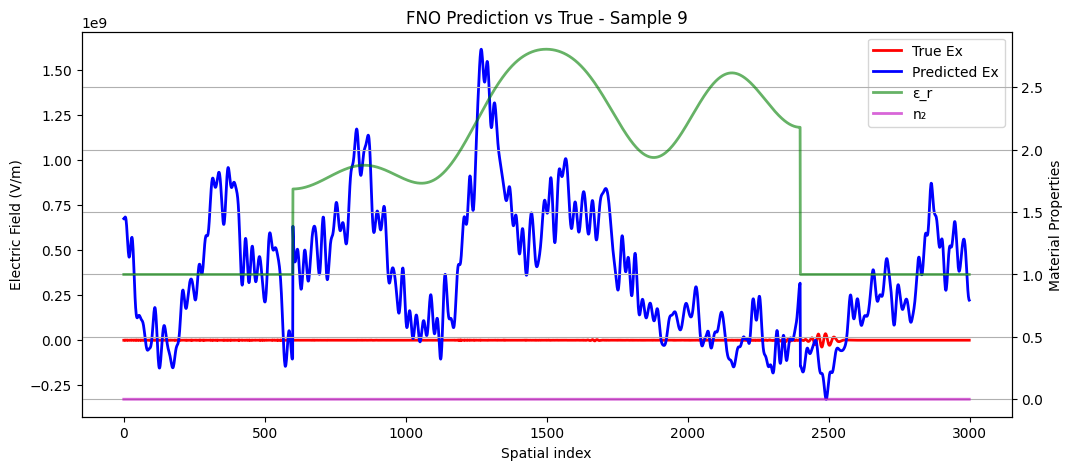

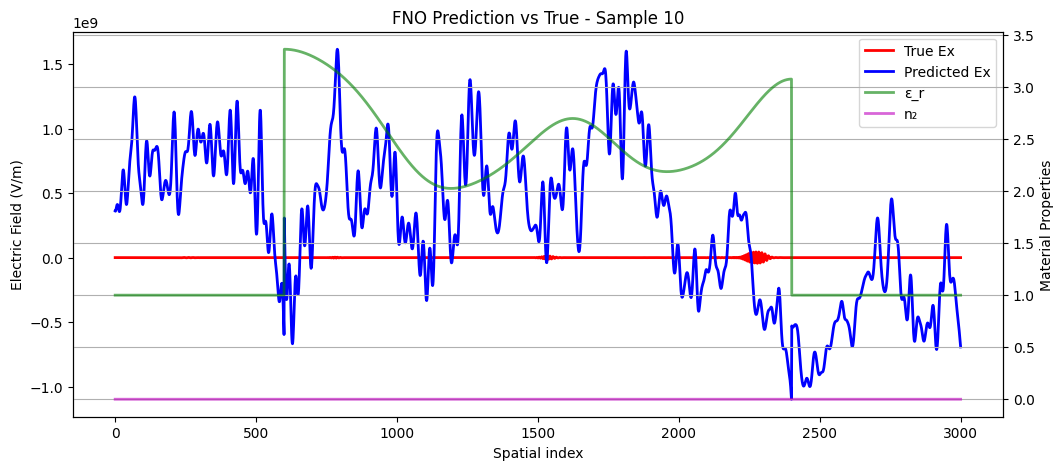

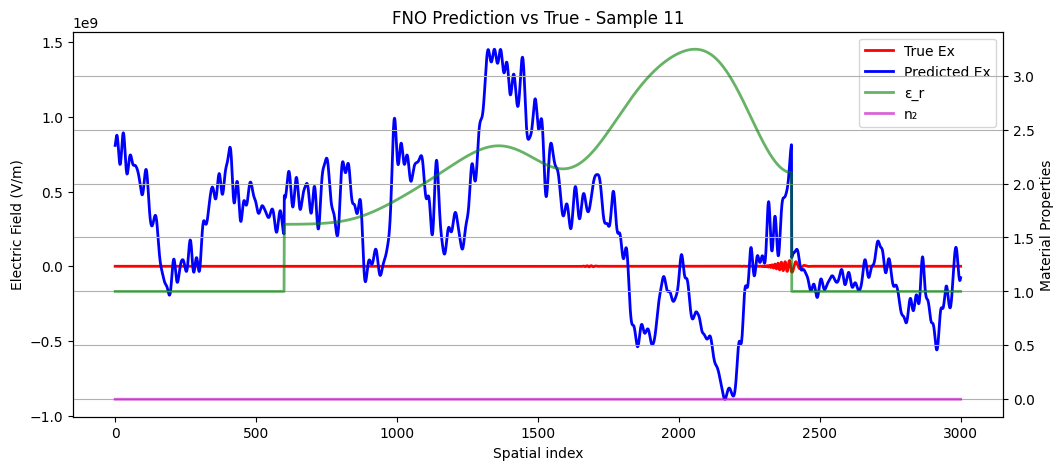

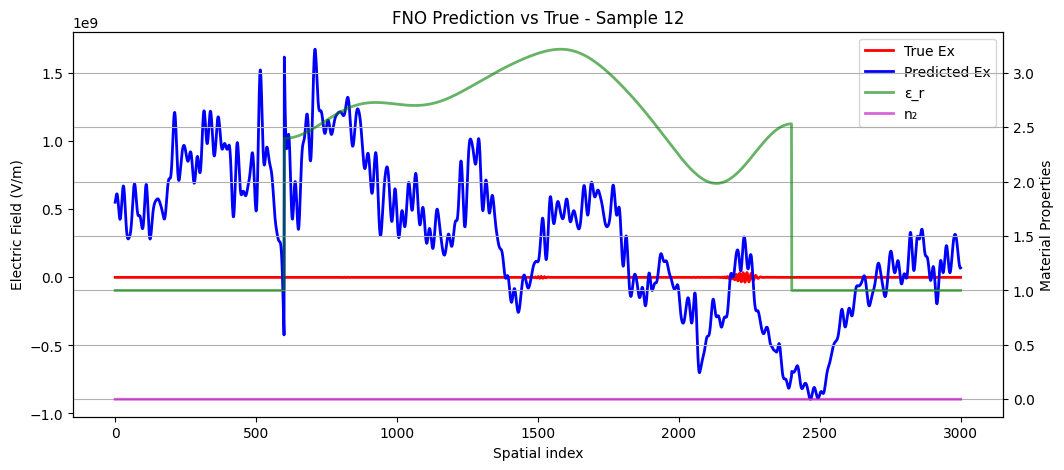

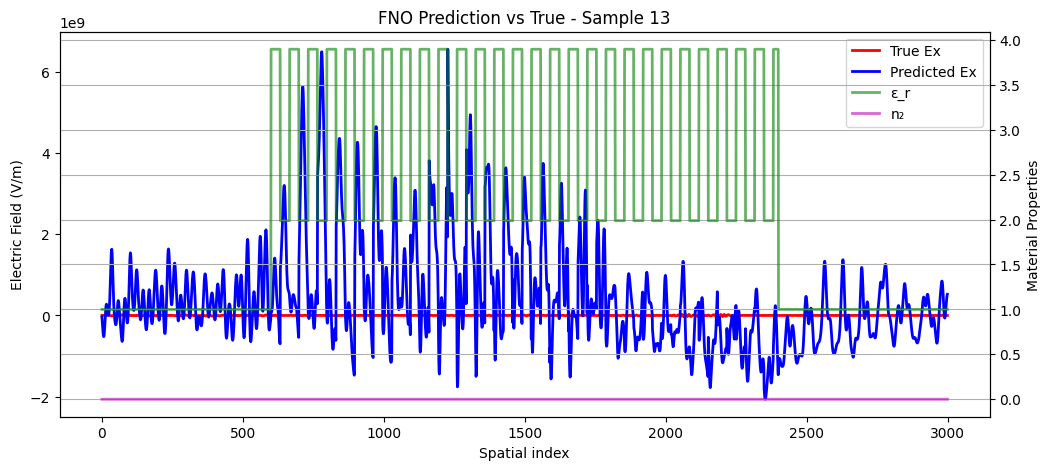

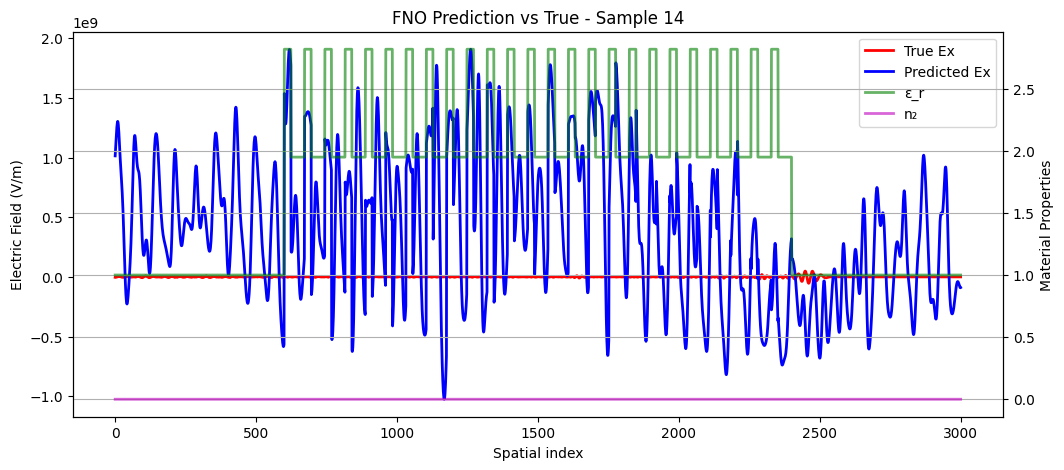

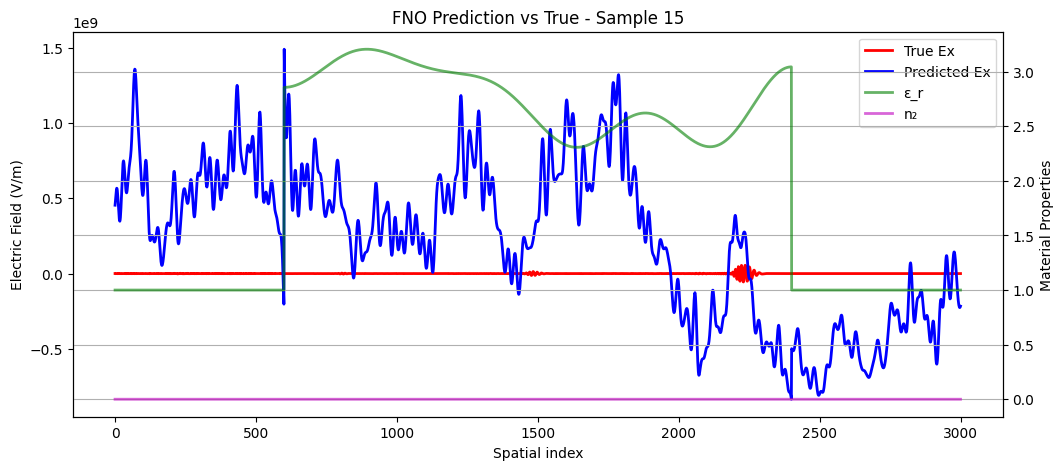

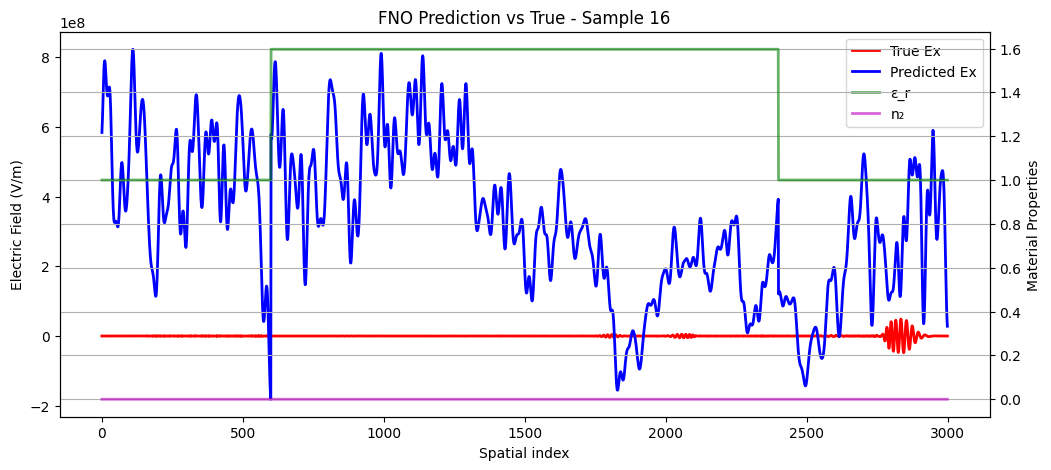

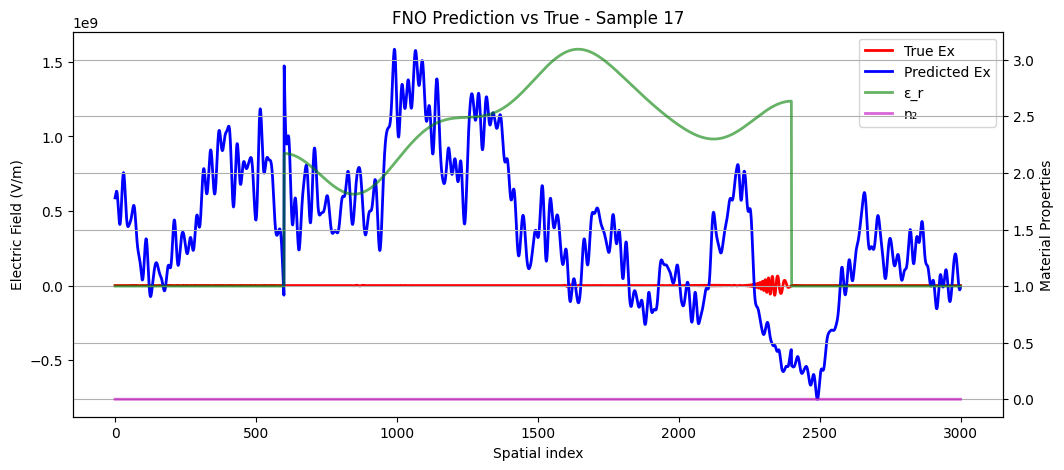

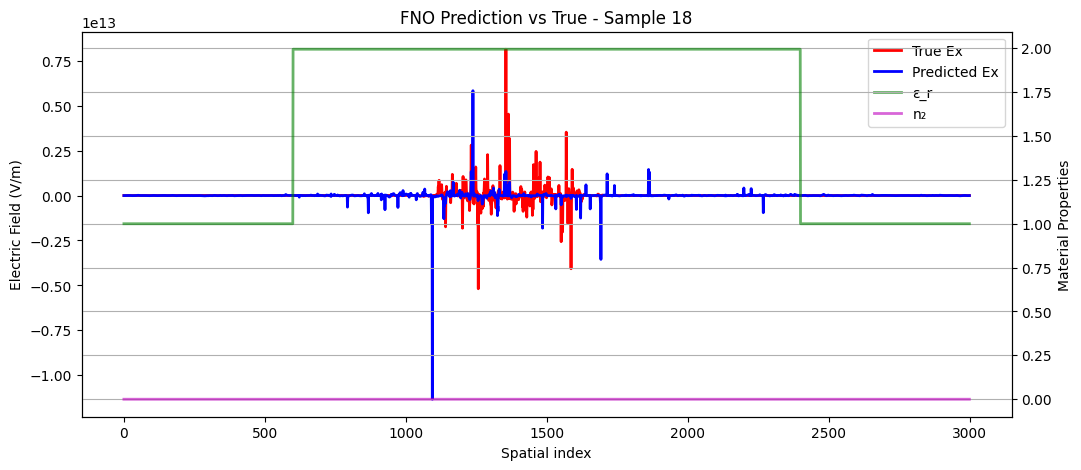

In [110]:
# Pick a test sample index
for sample_idx in range(19):
    plot_fno_prediction_with_material(
        x_coords,
        y_true=y_true_denorm[sample_idx],
        y_pred=y_pred_denorm[sample_idx],
        eps_r=eps_r_test[sample_idx],
        n2=n2_test[sample_idx],
        sample_idx=sample_idx
    )
